In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 

In [92]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")

In [93]:
base_symbol = "AVAX"
quote_symbol = "ETH"
timeframe = "4h"

base_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, f"{timeframe}_Data", f"{base_symbol}_USDT_{timeframe}.csv"),
    parse_dates=['timestamp']
)
quote_raw_df = pd.read_csv(
    os.path.join(DATA_DIR, f"{timeframe}_Data", f"{quote_symbol}_USDT_{timeframe}.csv"),
    parse_dates=['timestamp']
)

base_close  = base_raw_df['close']
quote_close = quote_raw_df['close']

In [94]:
base_close_series = base_close
quote_close_series = quote_close

shared_timestamps = base_close_series.index.intersection(quote_close_series.index)

base_price_aligned = base_close_series.loc[shared_timestamps]
quote_price_aligned = quote_close_series.loc[shared_timestamps]

base_column = base_price_aligned.to_numpy()
quote_column = quote_price_aligned.to_numpy()

<function matplotlib.pyplot.show(close=None, block=None)>

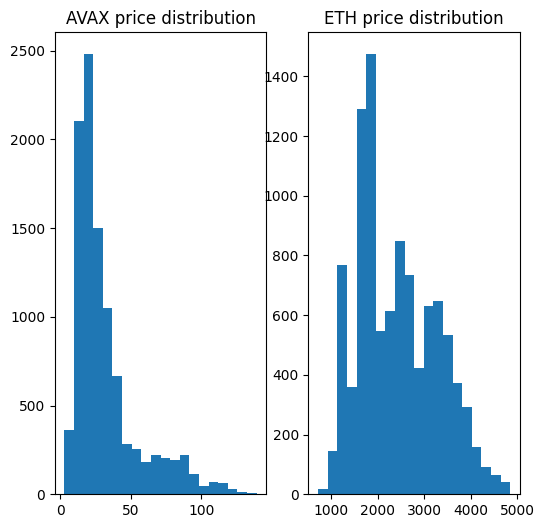

In [95]:
bins = 20

fig,(base_hist,quote_hist) = plt.subplots(nrows=1,ncols=2,figsize=(6,6))
base_hist.hist(base_column,bins=bins)
base_hist.set_title(f"{base_symbol} price distribution")

quote_hist.hist(quote_column,bins=bins)
quote_hist.set_title(f"{quote_symbol} price distribution")

plt.show

In [96]:
price_matrix = np.column_stack(
    [base_column,quote_column]
    )

price_centered_matrix = price_matrix - price_matrix.mean(axis=0)

In [97]:
U,Singular_Vals,V_Trans = np.linalg.svd(price_centered_matrix,full_matrices=False)
principal_vector_one = V_Trans[0]
principal_vector_two = V_Trans[1]

residual_vector = price_matrix @ principal_vector_two

In [98]:
base_raw_df['timestamp'] = pd.to_datetime(base_raw_df['timestamp'])
quote_raw_df['timestamp'] = pd.to_datetime(quote_raw_df['timestamp'])

base_raw_df = base_raw_df[['timestamp','close']].rename(columns={"close": "close_base_price"})
quote_raw_df = quote_raw_df[['timestamp','close']].rename(columns={"close":"close_quote_price"})

merged_df = pd.merge(base_raw_df,quote_raw_df,on='timestamp',how='inner')

In [99]:
window = int(0.10 * price_centered_matrix.shape[0])
min_window = int(0.05 * price_centered_matrix.shape[0])

In [100]:
spreads = abs(merged_df['close_base_price'].values - merged_df['close_quote_price'].values)

mean_spreads = pd.Series(spreads).rolling(window=window, min_periods=min_window).mean()
rolling_std  = pd.Series(spreads).rolling(window=window, min_periods=min_window).std().values

z_scores = (spreads - mean_spreads) / rolling_std

merged_df['spread'] = spreads
merged_df['mean_spreads'] = mean_spreads
merged_df['z_score'] = z_scores

In [101]:
residual_mean = residual_vector.mean()
residual_std = residual_vector.std(ddof=1)
residual_min = residual_vector.min()
residual_max = residual_vector.max()


print("Mean of residuals:", residual_mean)
print("Standard deviation of residuals:", residual_std)
print("Minimum residual:", residual_min)
print("Maximum residual:", residual_max)


Mean of residuals: 15.460807208488031
Standard deviation of residuals: 16.795889941816082
Minimum residual: -56.39826573325668
Maximum residual: 52.16296541046417


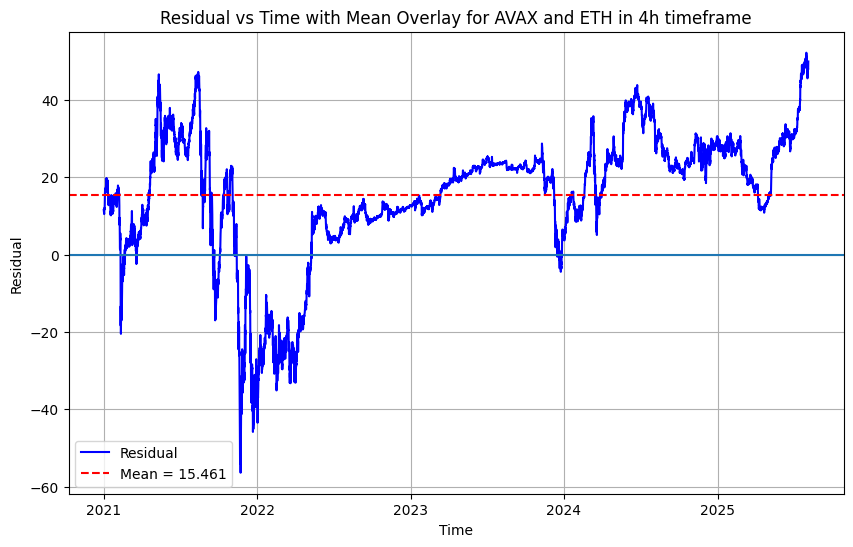

In [102]:
time = merged_df['timestamp']

plt.figure(figsize=(10,6))
plt.plot(time,residual_vector,label="Residual",color='blue')
plt.axhline(y=residual_mean,color='red',linestyle="--",label=f'Mean = {residual_mean:.3f}')
plt.axhline()

plt.xlabel('Time')
plt.ylabel('Residual')
plt.title(f'Residual vs Time with Mean Overlay for {base_symbol} and {quote_symbol} in {timeframe} timeframe')
plt.legend()
plt.grid(True)
plt.show()


In [103]:
print(base_raw_df)

                timestamp  close_base_price
0     2021-01-01 00:00:00            3.1085
1     2021-01-01 04:00:00            3.1753
2     2021-01-01 08:00:00            3.5259
3     2021-01-01 12:00:00            3.6472
4     2021-01-01 16:00:00            3.5644
...                   ...               ...
10056 2025-08-04 00:00:00           21.7700
10057 2025-08-04 04:00:00           21.9300
10058 2025-08-04 08:00:00           21.8400
10059 2025-08-04 12:00:00           22.3600
10060 2025-08-04 16:00:00           22.3800

[10061 rows x 2 columns]


<Axes: title={'center': 'AVAX price in 4h timeframe'}, xlabel='timestamp'>

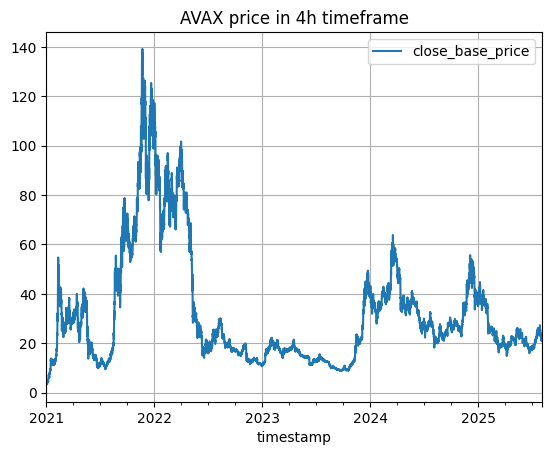

In [104]:
base_raw_df.plot(x='timestamp',y='close_base_price',title=f'{base_symbol} price in {timeframe} timeframe',grid=True)

<Axes: title={'center': 'ETH price in 4h timeframe'}, xlabel='timestamp'>

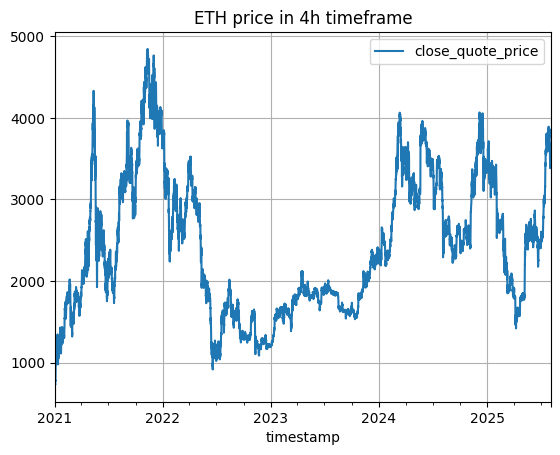

In [105]:
quote_raw_df.plot(x='timestamp',y='close_quote_price',title=f'{quote_symbol} price in {timeframe} timeframe',grid=True)

In [106]:
print(principal_vector_two)

[-0.99980725  0.01963301]


In [107]:
print(residual_std)

16.795889941816082
